# Illumination Classification Based on No-Reference Image Quality Assessment (NR-IQA)

This work is my own implementation of the method described in. 

https://dl.acm.org/doi/abs/10.1145/3314527.3314529
https://www.researchgate.net/publication/332538419_Illumination_Classification_based_on_No-Reference_Image_Quality_Assessment_NR-IQA

In [1]:
import os
import glob
import random

import cv2
import matplotlib.pyplot as plt
import numpy as np
import tqdm.notebook as tqdm

from skimage.measure import shannon_entropy
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report as cr, confusion_matrix as cm
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

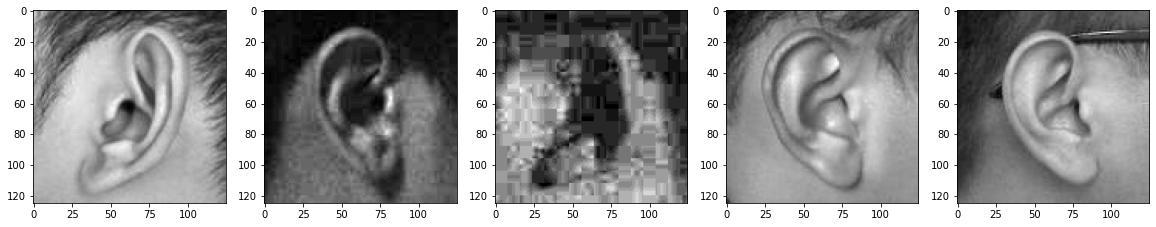

In [2]:
random.seed(0)
files = glob.glob('/kaggle/input/diast-vitveid/DIAST Variability Illuminated Thermal and Visible Ear Images Datasets/*/* Visible/*.jpg')
files = sorted(files)
random.shuffle(files)

random.seed()
k = 5
fig, axs = plt.subplots(1, k, figsize=(20, int(20 / k)))
for ax, file_ in zip(axs, random.choices(files, k=k)):
    ax.imshow(cv2.imread(file_, cv2.IMREAD_GRAYSCALE), cmap='gray')
plt.show()

random.seed(0)

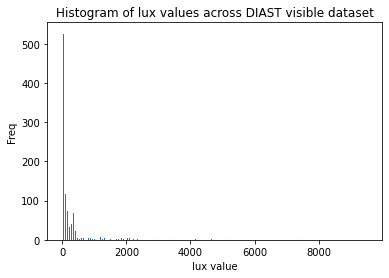

In [3]:
def get_lux(file_):
    """Extract the lux value that was used to take the image."""
    base = os.path.basename(file_)
    base, _ = os.path.splitext(base)
    lux = int(base.split('x')[-1].split('v')[0])
    return lux

lux_values = list(map(get_lux, files))
assert min(lux_values) >=1
assert max(lux_values) <= 9999
assert len(lux_values) == len(files)

fig = plt.figure()
plt.hist(lux_values, bins='auto', histtype='bar', ec='white')
plt.xlabel('lux value')
plt.ylabel('Freq')
plt.title("Histogram of lux values across DIAST visible dataset")
plt.show()

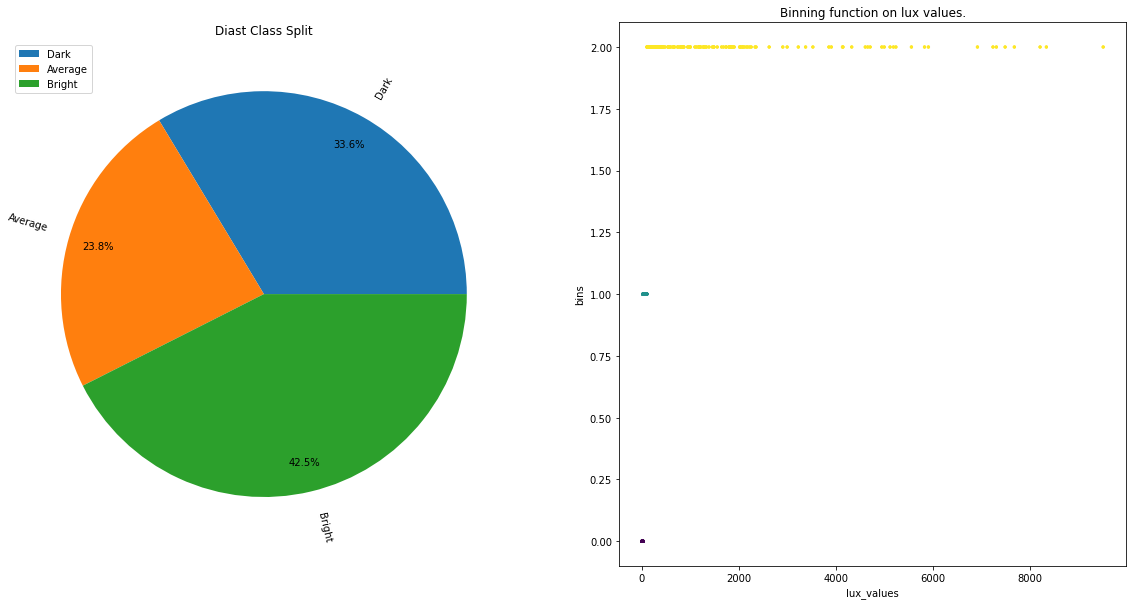

In [4]:
# Extract the class labels from the lux values
CLASS_NAMES = ['Dark', 'Average', 'Bright']
bins = [20, 100, max(lux_values)]  # Dark, Average, Bright - from the dataset.
f = lambda lux: next(bins.index(b) for b in bins if lux <= b)
y = np.array(list(map(f, lux_values)))  # 0=Dark, 1=Average, 2=Bright
assert min(y) == 0
assert max(y) == 2
assert len(y) == len(files)

unq, unq_cnts = np.unique(y, return_counts=True)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.pie(unq_cnts, rotatelabels=True, labels=np.array(CLASS_NAMES)[unq], autopct='%1.1f%%', pctdistance=0.85)
ax1.legend()
ax1.set_title('Diast Class Split')

ax2.scatter(lux_values, y, s=5, c=y)
ax2.set(xlabel='lux_values', ylabel='bins')
ax2.set_title('Binning function on lux values.')
plt.show()

In [5]:
# Extract the features that we want to use

def nric(img):
    """Extract the no reference features from image.
    
    Parameters
    ----------
    img: np.ndarray or path-like
        Grayscale image or path to image.
    
    Returns
    -------
    float
        The shannon entropy of the grayscale image.
    float
        The standard deviation of the grayscale image.
    float
        The mean of the grayscale image.
        
    """
    if isinstance(img, str):
        img = cv2.imread(img, cv2.IMREAD_GRAYSCALE)
        
    sd = np.std(img)
    me = np.mean(img)
    se = shannon_entropy(img)
    return se, sd, me

x = np.array(list(map(nric, tqdm.tqdm(files))))
assert len(x) == len(y)

  0%|          | 0/1100 [00:00<?, ?it/s]

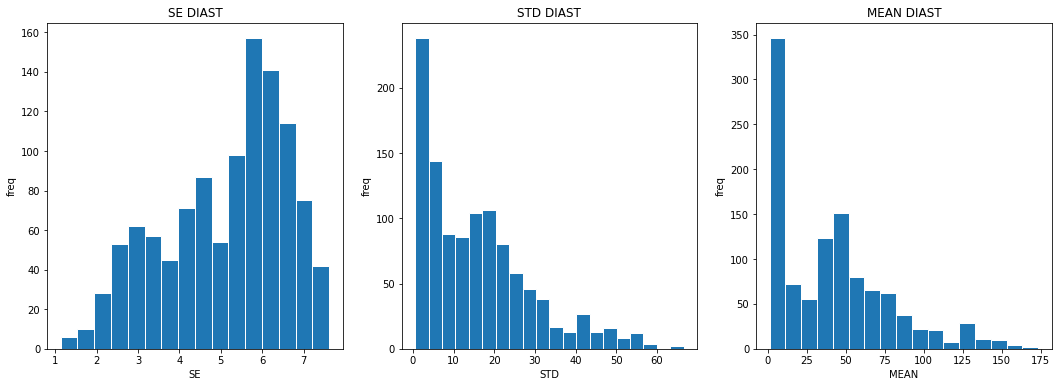

Metric Avg | Dark=0 | Average=1 | Bright=2
SE 3.4047971184226693 5.378320898612988 6.3415279264637245
STD 3.7160982076622533 14.028965820552248 26.515964672227657
MEAN 6.970778464864865 34.86395871755725 73.27404102564103


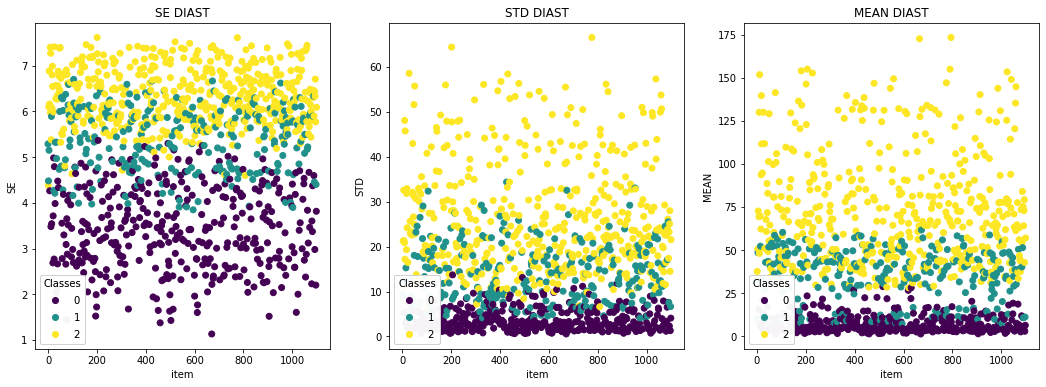

In [6]:
FEATURE_NAMES = ['SE', 'STD', 'MEAN']
k = len(FEATURE_NAMES)

fig, ax = plt.subplots(1, k, figsize=(18, 18/k))
for i, q in enumerate(FEATURE_NAMES):
    ax[i].hist(x[:, i], bins='auto', histtype='bar', ec='white')
    ax[i].set(xlabel=q, ylabel="freq")
    ax[i].set_title(q + ' DIAST')
plt.show()

print('Metric Avg | Dark=0 | Average=1 | Bright=2')
fig, ax = plt.subplots(1, k, figsize=(18, 18/k))
for i, q in enumerate(['SE', 'STD', 'MEAN']):
    scatter = ax[i].scatter(np.arange(0, len(y)), x[:, i], c=y)
    legend = ax[i].legend(*scatter.legend_elements(), loc="lower left", title="Classes")
    ax[i].add_artist(legend)
    ax[i].set(xlabel='item', ylabel=q)
    ax[i].set_title(q + ' DIAST')
    print(q, *[x[y == c][:, i].mean() for c in unq])
plt.show()

In [7]:
# Data split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0, stratify=y)

In [8]:
# Train RF
clf = RandomForestClassifier(random_state=0, class_weight='balanced')
clf.fit(x_train, y_train)

y_pred = clf.predict(x_test)

print(cr(y_true=y_test, y_pred=y_pred))
print(cm(y_true=y_test, y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.89      0.92      0.91        74
           1       0.72      0.63      0.67        52
           2       0.89      0.93      0.91        94

    accuracy                           0.85       220
   macro avg       0.83      0.83      0.83       220
weighted avg       0.85      0.85      0.85       220

[[68  6  0]
 [ 8 33 11]
 [ 0  7 87]]


In [9]:
# Train kNN
k = 5
knn = KNeighborsClassifier(k)
knn.fit(x_train, y_train)

y_pred = knn.predict(x_test)

print(cr(y_true=y_test, y_pred=y_pred))
print(cm(y_true=y_test, y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.89      0.91      0.90        74
           1       0.60      0.56      0.58        52
           2       0.85      0.87      0.86        94

    accuracy                           0.81       220
   macro avg       0.78      0.78      0.78       220
weighted avg       0.80      0.81      0.81       220

[[67  7  0]
 [ 8 29 15]
 [ 0 12 82]]
